In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install lightning


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from torchmetrics import Accuracy

sns.set_theme(style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus":False})

import torch
import torchmetrics
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
pl.seed_everything(seed)

INFO: Seed set to 1
INFO:lightning.fabric.utilities.seed:Seed set to 1


1

In [ ]:
# Data Augmentation and Resizing
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to match Inception v3 input
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by duplicating channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for Inception v3
])  # <-- **Closing square bracket added here**

# Load the dataset
full_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split the dataset
total_size = len(full_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = int(0.1 * total_size)    # 10% for validation
test_size = total_size - train_size - val_size  # Rest for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Smaller batch size due to larger image size
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check the first batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Batch shape:", images.shape)  # Should print [Batch size, 3, 299, 299]


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Batch shape: torch.Size([32, 3, 299, 299])


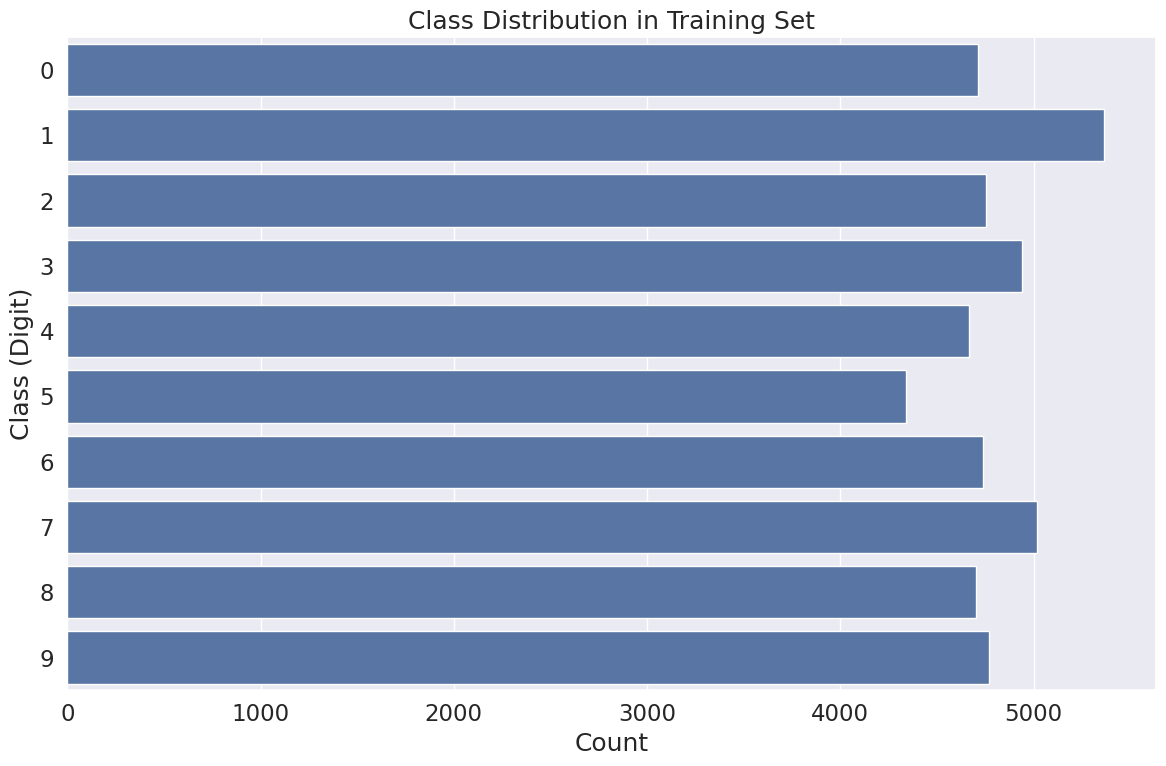

In [ ]:


# Define class names for MNIST
class_names = [str(i) for i in range(10)]


class_count = [0] * len(class_names)
for idx in train_dataset.indices:
    class_label = full_dataset.targets[idx].item()
    class_count[class_label] += 1

# Create a DataFrame for visualization
df = pd.DataFrame({
    "Class": class_names,
    "Count": class_count
})

# Plotting
plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.title('Class Distribution in Training Set')
plt.xlabel('Count')
plt.ylabel('Class (Digit)')
plt.tight_layout()
plt.show()


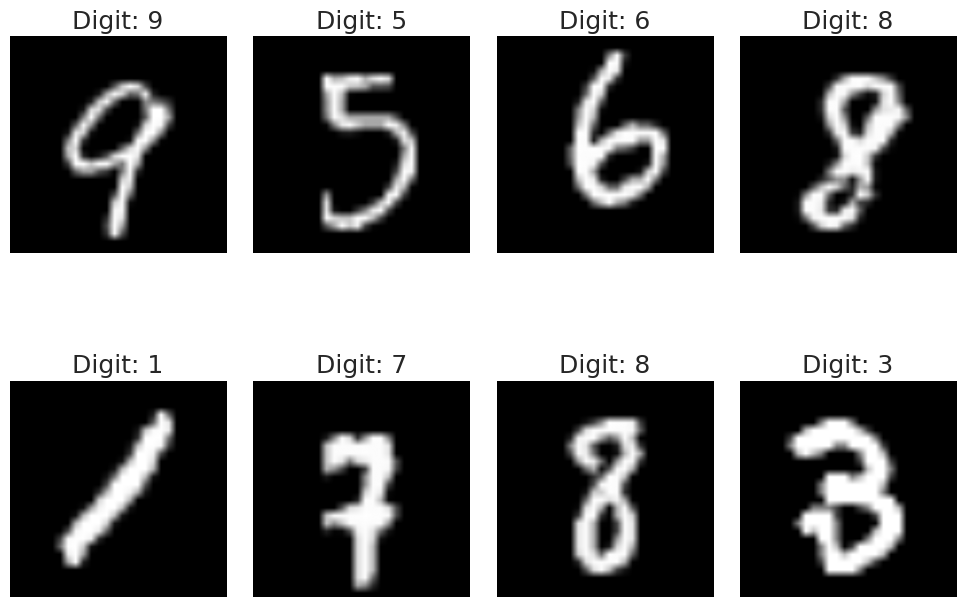

In [ ]:


def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = np.mean(inp, axis=2)
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of images and labels
images, labels = next(iter(val_loader))

# Plot the images
plt.figure(figsize=(10, 8), dpi=100)
for i in range(8):  # Only plotting 8 images
    ax = plt.subplot(2, 4, i + 1)  # Use a 2x4 grid for 8 images
    imshow(images[i], f'Digit: {labels[i].item()}')  # Add the digit as the title
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import pytorch_lightning as pl
from torch import nn

class LitInceptionV3(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        # Load pre-trained Inception v3 model
        self.model = models.inception_v3(pretrained=True)

        # Modify the final fully connected layer for MNIST (10 classes)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

        # Define accuracy metric
        self.accuracy = pl.metrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.accuracy(logits, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-4)


In [ ]:
# Trainer configuration
trainer = pl.Trainer(
    max_epochs=1,
    enable_progress_bar=True,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=15),
        pl.callbacks.ModelCheckpoint(dirpath='checkpoints', monitor='val_acc', mode='max', save_top_k=1)
    ],
    logger=pl.loggers.CSVLogger(save_dir='logs'),
    accelerator='auto',
    devices=1
)

# Initialize the model correctly
model = LitInceptionV3(num_classes=10)

# Train the model
trainer.fit(model, train_loader, val_loader)

# Test the model
test_result = trainer.test(dataloaders=test_loader)
print(test_result)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 192MB/s] 


AttributeError: module 'pytorch_lightning' has no attribute 'metrics'